# Project - Twitter Speech Detection

In [ ]:
# !pip install pyspellchecker
# !pip install demoji
# !pip install contractions

In [20]:
import re
import nltk
from nltk import pos_tag
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.stem.wordnet import WordNetLemmatizer  # used for lemmatizer
import pandas as pd
import string
import contractions
from spellchecker import SpellChecker
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('seaborn-dark-palette')
%config InlineBackend.figure_format = 'retina'
from tqdm import tqdm
tqdm.pandas()
import warnings
warnings.filterwarnings("ignore")
import demoji

In [2]:
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\mansi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\mansi\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mansi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\mansi\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

### Loading CSV data in pandas dataframe

In [3]:
df=pd.read_csv('labeled_data.csv')

In [4]:
df.head()

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


In [5]:
df.isnull().sum()

Unnamed: 0            0
count                 0
hate_speech           0
offensive_language    0
neither               0
class                 0
tweet                 0
dtype: int64

In [6]:
df.duplicated().sum()

0

In [7]:
df['class'].unique()

array([2, 1, 0], dtype=int64)

### Here,
__class=0 --> hate speech__

__class=1 --> offensive speech__

__class=2 --> Neither__

#### We only require class and tweet columns

In [8]:
df.drop(['Unnamed: 0','count','hate_speech','offensive_language','neither'],axis=1,inplace=True)

In [9]:
df['class'].value_counts()

1    19190
2     4163
0     1430
Name: class, dtype: int64

#### Data is imbalanced

<AxesSubplot:xlabel='class', ylabel='count'>

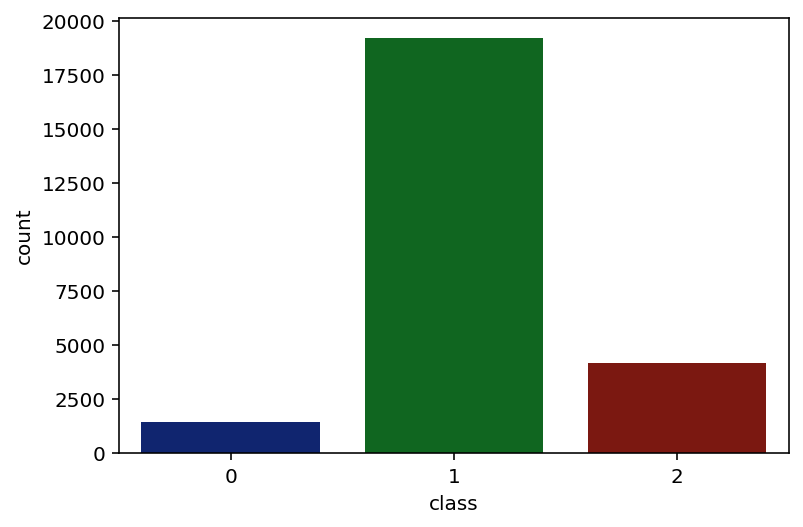

In [12]:
sns.countplot('class',data=df)

### Displaying some comments

In [13]:
df[df['class']==0].iloc[10,1] # Hate Speech

'"@jayswaggkillah: Jackies a retard #blondeproblems" At least I can make a grilled cheese!'

In [14]:
df[df['class']==1].iloc[10,1] # Offensive Speech

'" Murda Gang bitch its Gang Land "'

In [15]:
df[df['class']==2].iloc[10,1] # Neither

'"@El_Grillo1: Pit Bulls Photographed As Lovely Fairy Tale Creatures http://t.co/Q0Sm89oOLh&#8221;\n\nThey *are* fairy tale creatures.'

#### We will do preprocessing to remove:

- usernames
- links
- stopwords
- punctuations
- contraction expansion


In [16]:
# ======================================================================================================================
# Creating list of Stop-words (pre-processing)
# ======================================================================================================================
new_stopwords=['say', 'get', 'go', 'know', 'may', 'need', 'make', 'see', 'want', 'come', 'take', 'use','life','money',
               'little','even','head','right','eat','laugh','well','red','bad','best','year','today','watch','win','play',
               'new','game','good','would', 'can', 'zero', 'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine', 'ten', 'may',
           'also', 'across', 'among', 'beside', 'yet', 'within', 'mr', 'bbc', 'image', 'getty','woman','boy','guy'
           'de', 'en', 'caption', 'copyright', 'something', 'tag', 'wait', 'set', 'put', 'add', 'post', 'give', 'way', 'check', 'think',
          'www', 'must', 'look', 'call', 'minute', 'com', 'thing', 'much', 'happen','still','tell','talk','never',
          'quarantine', 'day', 'time', 'week', 'amp', 'find','None','man','girl','really','real','people','love','like','let','back' ]
stop_words = set(list(stopwords.words('english')) + ['"', '|'] + new_stopwords)

# ======================================================================================================================
# Creating list of Emoticons (pre-processing)
# ======================================================================================================================
# Happy Emoticons
emoticons_happy = {':-)', ':)', ';)', ':o)', ':]', ':3', ':c)', ':>', '=]', '8)', '=)', ':}', ':^)', ':-D', ':D', '8-D',
               '8D', 'x-D', 'xD', 'X-D', 'XD', '=-D', '=D', '=-3', '=3', ':-))', ":'-)", ":')", ':*', ':^*', '>:P',
               ':-P', ':P', 'X-P', 'x-p', 'xp', 'XP', ':-p', ':p', '=p', ':-b', ':b', '>:)', '>;)', '>:-)', '<3'}

# Sad Emoticons
emoticons_sad = {':L', ':-/', '>:/', ':S', '>:[', ':@', ':-(', ':[', ':-||', '=L', ':<', ':-[', ':-<', '=\\', '=/',
             '>:(', ':(', '>.<', ":'-(", ":'(", ':\\', ':-c', ':c', ':{', '>:\\', ';('}

# Combine sad and happy emoticons
emoticons = emoticons_happy.union(emoticons_sad)

In [91]:
# ======================================================================================================================
# Removing links (pre-processing)
# ======================================================================================================================
def strip_links(text):
    all_links_regex = re.compile('http\S+|www.\S+', re.DOTALL)
    text = re.sub(all_links_regex, '', text)
    return text

# ======================================================================================================================
# Removing Punctuations (pre-processing)
# ======================================================================================================================
def remove_punctuation(text):
    text = re.sub(r'@\S+', '', text)  # Delete Usernames

    # remove punctuation from each word (Replace hashtags with space, keeping hashtag context)
    text = re.sub(r'#', '', text)  # Delete the hashtag sign

    for separator in string.punctuation:
        if separator not in ["'"]:
            text = text.replace(separator, ' ')

    return text

# ======================================================================================================================
# Removing Emojis (pre-processing)
# ======================================================================================================================

def remove_emoji(text):
    text= demoji.replace(text, "") 
    return text

# ======================================================================================================================
# Removing Contractions (pre-processing)
# ======================================================================================================================

def get_contractions(text):
    commonSMS = { 
    "Ain’t" : "Am not",
    "Wanna" : "Want to",
    "Whatcha" : "What have you",
    "Kinda" : "Kind of",
    "Sorta" : "Sort of",
    "Outta" : "Out of",
    "Alotta" : "A lot of",
    "Lotsa" : "Lots of",
    "Mucha" : "Much of",
    "Cuppa" : "Cup of",
    "Dunno" : "Don’t know",
    "Lemme" : "Let me",
    "Gimme" : "Give me",
    "Tell’em" : "Tell them",
    "Imma" : "I am going to",
    "Gonna" : "Going to",
    "Needa" : "Need to",
    "Oughta" : "Ought to",
    "Hafta" : "Have to",
    "Hasta" : "Has to",
    "Usta" : "Used to",
    "Supposta" : "Supposed to",
    "Gotta" : "Got to",
    "Cmon" : "Come on",
    "Ya" : "You",
    "Shoulda" : "Should have",
    "Shouldna" : "Should not have",
    "Wouldna" : "Would not have",
    "She’da" : "She would have",
    "Coulda" : "Could have",
    "Woulda" :"Would have",
    "Mighta" : "Might have",
    "Mightna" : "Might not have",
    "Musta" : "Must have",
    "Mussna" : "Must not have",
    "Dontcha" : "Do not you",
    "Wontcha" : "Would not you",
    "Whatcha" : "What are you",
    "Betcha" : "Bet you",
    "Gotcha" : "Got you",
    "D’you" : "Do you",
    "Didntcha" : "Did not you",
    "Dija" : "Did you",
    "S’more" : "Some more",
    "Layder" : "Later",
    "R": "are",
    "N":"and",
    "D":'the',
    "BRB":"Be right back",
    "IKR":"I know, right",
    "ILY":"I love you",
    "LMFAO":"Laughing my freaking ass off",
    "NVM": "Never mind",
    "OFC": "Of course",
    "ROFL":"Rolling on the floor laughing",
    "SMH": "Shaking my head",
    "STFU": "Shut the fuck up",
    "YOLO": "You only live once",
    "MMB":"Message me back",
    "YNT":"Why not",
    "BW":"Between",
    "TC":"Take care",
    "MU":"Miss you",
    "S2R":"Send to receive",
    "NVM":"Never mind",
    "CTN":"Can’t talk now",
    "B4":"Before",
    "FTW":"For the win",
    "HW":"Homework",
    "W8":"Wait",
    "PC":"Personal computer",
    "ITT":"In this thread",
    "RBTL":"Read between the lines",
    "ETA":"Estimated time of arrival",
    "XOXO":"Hugs and kisses",
    "AFK":"Away from keyboard",
    "BuBye":"Bye Bye",
    "DIY":"Do it yourself",
    "MW":"On my way",
    "SD":"Sweet dreams",
    "YW":"You are welcome",
    "RL":"Real life",
    "SRY":"Sorry",
    "DIKU":"Do I know you",
    "IDGI":"I do not get it",
    "IDC":"I do not care",
    "IDK":"I do not know",
    "CFY":"Calling for you",
    "AAMOF":"As a matter of fact",
    "TYT":"Take your time",
    "TY":"Thank you",
    "GG":"Good game",
    "IRL":"In real life",
    "GJ":"Good job",
    "POV":"Point of view",
    "R8":"Right",
    "BTW":"By the way",
    "SU":"Shut up",
    "NC":"No comment",
    "SEC":"Second",
    "IMO":"In my opinion",
    "JK":"Just kidding",
    "KK":"Okay cool",
    "PPL":"People",
    "GTG":"Got to go",
    "NP":"No problem",
    "ROFL":"Rolling on the floor laughing",
    "RIP":"Rest in peace",
    "SMH":"Shaking my head",
    "PLZ":"Please",
    "RT":"Real time",
    "CYL":"Call you later",
    "GM":"Good morning",
    "GR8":"Great",
    "YOLO":"You only live once",
    "GN":"Goodnight",
    "WD":"Well done",
    "TTYS":"Talk to you soon",
    "BD":"Big deal",
    "GL":"Good luck",
    "L8R":"Later",
    "TTYL":"Talk to you later",
    "TMI":"Too much information",
    "IM":"Instant message",
    "ASIC":"As soon as I can",
    "TCO":"Taken care of",
    "BBIAB":"Be back in a bit",
    "B4N" :"Bye for Now",
    "HU":"Hug you",
    "QT":"Cutie",
    "MSG":"Message",
    "LOL":"laugh out loud",
    "ZZZ":"Sleeping",
    "IC":"I see",
    "JJ":"Just joking",
    "F2F":"Face to face",
    "BRB":"Be Right Back",
    "CTN":"Can not talk now",
    "TTYN":"Talk to you never",
    "BFF":"Best Friends Forever",
    "GBTW":"Get back to work",
    "LMAO":"laughing my ass off",
    "BC":"Because",
    "PLS":"Please",
    "NOOB":"Newbie",
    "WTF":"What the fuck",
    "CU":"See you",
    "FAB":"Fabulous",
    "THX":"Thanks",
    "CUL":"See you later",
    "COZ":"Because",
    "CUZ":"Because",
    "CAUSE":"Because",
    "CYA":"See You",
    "Y":"Why",
    "TXT":"Text",
    "KU":"Kiss you",
    "FYI":"For your information",
    "OOO":"Out of office",
    "FAQ":"Frequently asked questions",
    "LU":"Love you",
    "AKA":"Also known as",
    "THO":"Though",
    "BAU":"Business as usual",
    "HBU":"How about you",
    "LMAO":"Laughing my ass off",
    "AFAIK" :"As far as I know",
    "BA3":"Battery",
    "GMV":"Got my vote",
    "RT":"Retweet",
    "IMHO":"In my humble opinion",
    "HTH":"Here to help",
    "BF":"Boyfriend",
    "PC":"Personal computer",
    "L8":"Late",
    "ASAP":"As soon as possible",
    "GONNA":"Going to",
    "GUNNA":"Going to",
    "OMG":"Oh my God",
    "LAM":"Leave a message",
    "NTN":"No thanks needed",
    "SS":"So sorry",
    "M8":"Mate",
    "2MORO":"Tomorrow",
    "LNG":"Long",
    "pic":"picture",
    "OMG":"Oh my god",
    "GAL":"Girl",
    "DND":"Do not disturb",
    "10Q":"Thank you",
    "2B":"To be",
    "4EVA":"Forever",
    "2MOR" :"Tomorrow",
    "YT":"YouTube",
    "utube": "Youtube",
    "der":"there",
    "wrk":"work",
    "tv":"television",
    "lol":"Laugh out loud",
    "4got":"Forgot",
    "yr":"year",
    "hr":"hour",
    "b4":"before",
    "bout":"about",
    "c":"see",
    "dat":"that",
    "tellin":"telling"    
    }
    new_dict = dict((k.lower(), v.lower()) for k, v in  commonSMS.items())   
    text_decontracted = []

    for word in text.split():
        if word in new_dict:
            word = new_dict[word]
        text_decontracted.append(word)

    text = ' '.join(text_decontracted)
    return text

# ======================================================================================================================
# Removing Spelling mistakes (pre-processing)
# ======================================================================================================================

'''To perform spelling mistake correction, you first need to make sure the word 
is not absurd or from slang like, caaaar, amazzzing etc. with repeated alphabets. 
'''
def reduce_lengthening(text):
    pattern = re.compile(r"(.)\1{2,}")
    return pattern.sub(r"\1\1", text)

'''use Pyspellchecker library from Python for correcting spellings'''

def spell_checker(text):
    spell = SpellChecker()
    text=' '.join(str(spell.correction(w)) for w in text.split())
    return text

# ======================================================================================================================
# Removing Non-alphanumeric words (pre-processing)
# ======================================================================================================================

# function to keep only alpharethmetic values
def only_alpha(tokenized_text):
    text_alpha = []
    for word in tokenized_text:
        word_alpha = re.sub('[^a-z A-Z]+', ' ', word)
        text_alpha.append(word_alpha)
    return text_alpha

# ======================================================================================================================
# Applying Lemmatization(pre-processing)
# ======================================================================================================================

# convert POS tag to wordnet tag in order to use in lemmatizer
lemmatizer = WordNetLemmatizer()

def nltk_pos_tagger(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:          
        return None
#lemmatizing
def lemmatizing(tokenized_text):

    nltk_tagged = nltk.pos_tag(tokenized_text)  
    wordnet_tagged = map(lambda x: (x[0], nltk_pos_tagger(x[1])), nltk_tagged)
    lemma_list = []

    for word, tag in wordnet_tagged:
        if tag is None:
            lemma_list.append(word)
        else:        
            lemma_list.append(lemmatizer.lemmatize(word, tag))
    return lemma_list


In [22]:
 def preprocessing(text):
        #lower text
        text = text.lower().strip()

        #remove punctuations and links
        text = remove_punctuation(strip_links(text))

        # remove emails
        text = re.sub('\S*@\S*\s?', '', text)

        # remove rt and via in case of tweet data
        text = re.sub(r"\b(rt|RT)\b", "", text)
        text = re.sub(r"\b(via|VIA)\b", "", text)
        text = re.sub(r"\b(it|IT)\b", "", text)
        text = re.sub(r"\b(btu|BTu)\b", "", text)
        text = re.sub(r"\b(bt|BT )\b", "", text)


        # format contractions without apostrophe in order to use for contraction replacement
        text = re.sub(r"\b(s|'s)\b", " is ", text)
        text = re.sub(r"\b(ve|'ve)\b", " have ", text)
        text = re.sub(r"\b(nt|'nt| 't)\b", " not ", text)
        text = re.sub(r"\b(re|'re)\b", " are ", text)
        text = re.sub(r"\b(d|'d)\b", " would ", text)
        text = re.sub(r"\b(ll|'ll)\b", " will ", text)
        text = re.sub(r"\b(m|'m)\b", " am", text)

        '''replace consecutive non-ASCII characters with a space
        examples=भारत (used for websites in India), 网络 (the .NET equivalent in China),קום(the .COM equivalent in Hebrew)
                  இந்தியா (meaning ‘Tamil’ for India, which is a language spoken in parts of India)
        '''
        text = re.sub(r'[^\x00-\x7F]+', ' ', text)

        # remove emojis from text
        #text = self.emoji_pattern.sub(r'', text)
        text=remove_emoji(text)

        # substitute contractions with full words
        #english contractions
        text=contractions.fix(text)
        #Most common internet contractions
        text = get_contractions(text)

        #Check for spelling corrections
        text=reduce_lengthening(text)
        text=spell_checker(text)

        return text


In [ ]:
### was taking too much time so made two functions

In [ ]:
def lemmatizing(text):
        # tokenize text
        tokenized_text = word_tokenize(text)

        # remove all non alpharethmetic values
        tokenized_text = only_alpha(tokenized_text)

        # lemmatize / stem words
        lemmatized_text =lemmatizing(tokenized_text)


        filtered_text = []
        # looping through conditions
        for word in lemmatized_text:
            word = word.strip()
            # check tokens against stop words, emoticons and punctuations
            # biggest english word: Pneumonoultramicroscopicsilicovolcanoconiosis (45 letters)
            if (word not in stop_words and word not in emoticons and word not in string.punctuation
                and not word.isspace() and len(word) > 2 and len(word) < 46):
                
                filtered_text.append(word)



        return filtered_text

In [24]:
df['clean_text'] = df['tweet'].progress_apply(preprocessing)

100%|██████████████████████████████████████████████████████████████████████████| 24783/24783 [1:30:09<00:00,  4.58it/s]


In [25]:
df['clean_text'] = df['clean_text'].progress_apply(lemmatizing)

100%|███████████████████████████████████████████████████████████████████████████| 24783/24783 [00:39<00:00, 628.37it/s]


In [26]:
df['clean_text']

0                  [complain, clean, house, always, trash]
1               [dat, cold, toga, coffin, hoe, est, place]
2        [dawg, ever, fuck, bitch, start, cry, confuse,...
3                                                 [tranny]
4           [shit, hear, might, true, might, faker, bitch]
                               ...                        
24778    [mutha, lie, trash, mine, bible, scripture, hymn]
24779    [break, wrong, heart, baby, drive, redneck, cr...
24780                   [young, buck, nigger, fuckin, dis]
24781                     [youu, wild, bitch, tellin, lie]
24782    [ruffle, ntac, eileen, dahlia, beautiful, colo...
Name: clean_text, Length: 24783, dtype: object

In [27]:
df['clean']=df['clean_text'].progress_apply(lambda x:" ".join(x))

100%|███████████████████████████████████████████████████████████████████████| 24783/24783 [00:00<00:00, 1118905.46it/s]


In [29]:
df.head()

,class,tweet,clean_text,clean
0,2,!!! RT @mayasolovely: As a woman you shouldn't...,"[complain, clean, house, always, trash]",complain clean house always trash
1,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,"[dat, cold, toga, coffin, hoe, est, place]",dat cold toga coffin hoe est place
2,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,"[dawg, ever, fuck, bitch, start, cry, confuse,...",dawg ever fuck bitch start cry confuse shit
3,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...,[tranny],tranny
4,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...,"[shit, hear, might, true, might, faker, bitch]",shit hear might true might faker bitch


In [30]:
df.drop('clean_text', axis=1, inplace=True)

### Saving clean data in a separate file for ease

In [32]:
df.to_csv('clean_data.csv', index=None)